In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
from tqdm import tqdm
import os
import argparse
import pickle
import numpy as np
from nnlib.nnlib import utils
from nnlib.nnlib.visualizations import savefig
from modules.bound_utils import estimate_fcmi_bound_classification
import methods

In [4]:
%matplotlib notebook
import matplotlib
from matplotlib import pyplot as plt
from nnlib.nnlib.matplotlib_utils import set_default_configs
import seaborn
set_default_configs(plt, seaborn)

In [5]:
class NestedDict(dict):
    def __missing__(self, key):
        self[key] = type(self)()
        return self[key]

# MNIST 4 vs 9 (standard algorithm)


In [10]:
results_dir = "results"
exp_name = "fcmi-mnist-4vs9-CNN"
n_seeds = 5
n_S_seeds = 30
ns = [75, 250, 1000, 4000]
epochs = np.arange(1, 11) * 20
num_classes = 2

# plot

In [12]:
results_file_path = os.path.join(results_dir, exp_name, 'results.pkl')
with open(results_file_path, 'rb') as f:
    results = pickle.load(f)

<IPython.core.display.Javascript object>


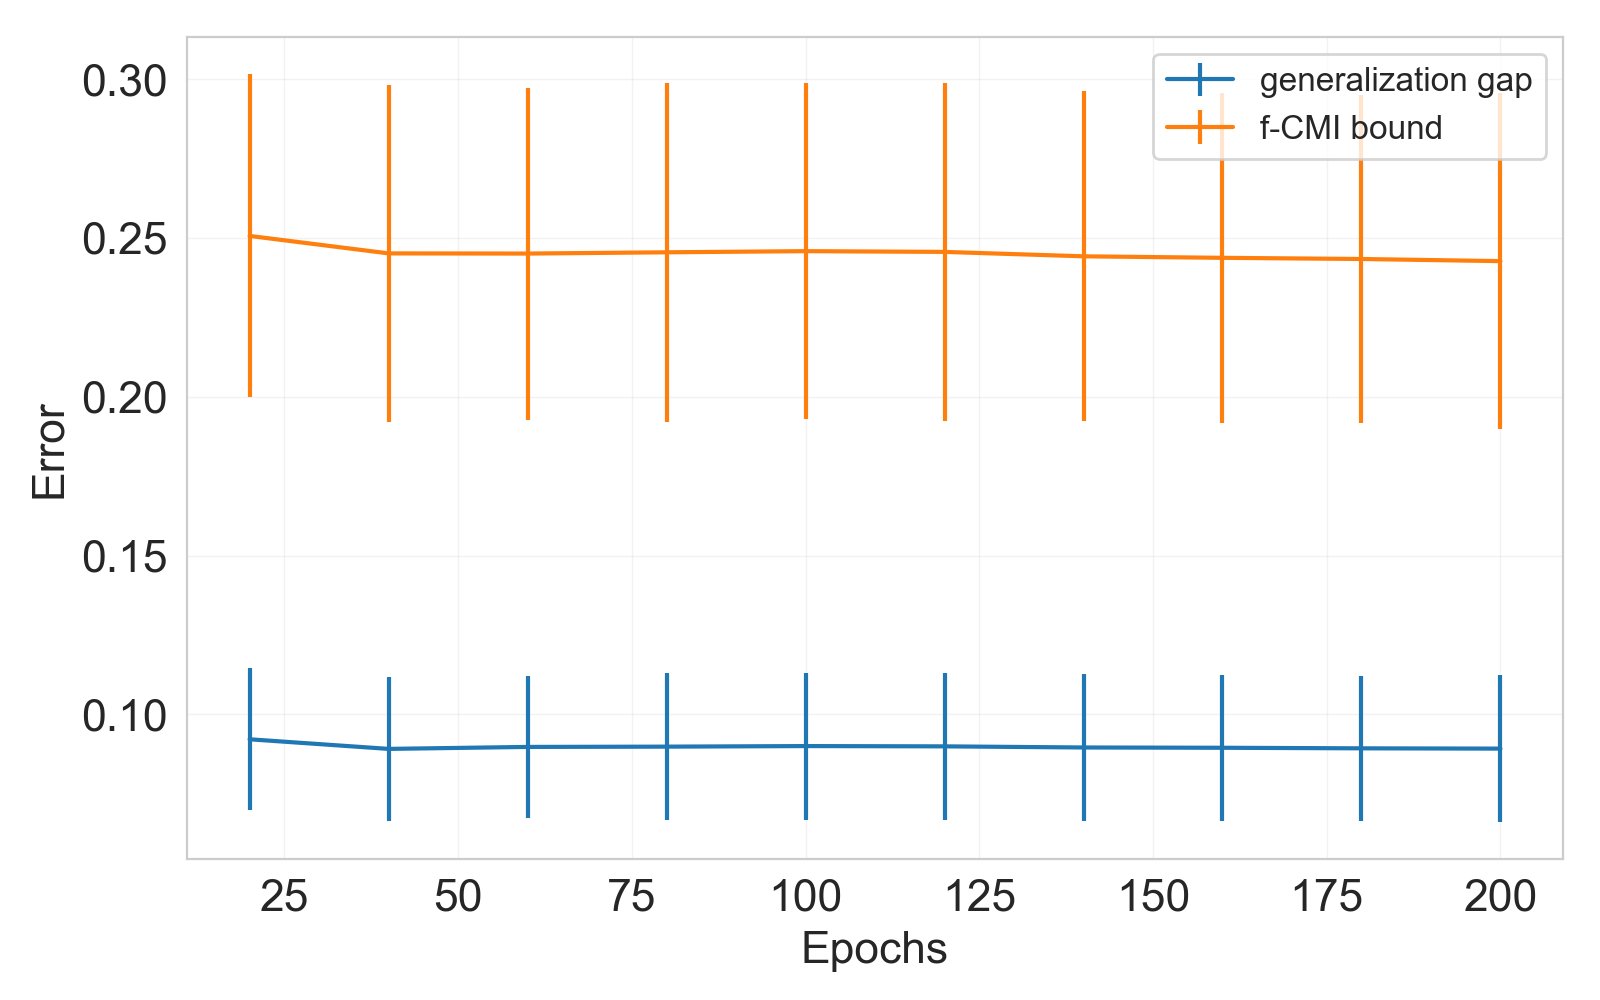

<IPython.core.display.Javascript object>


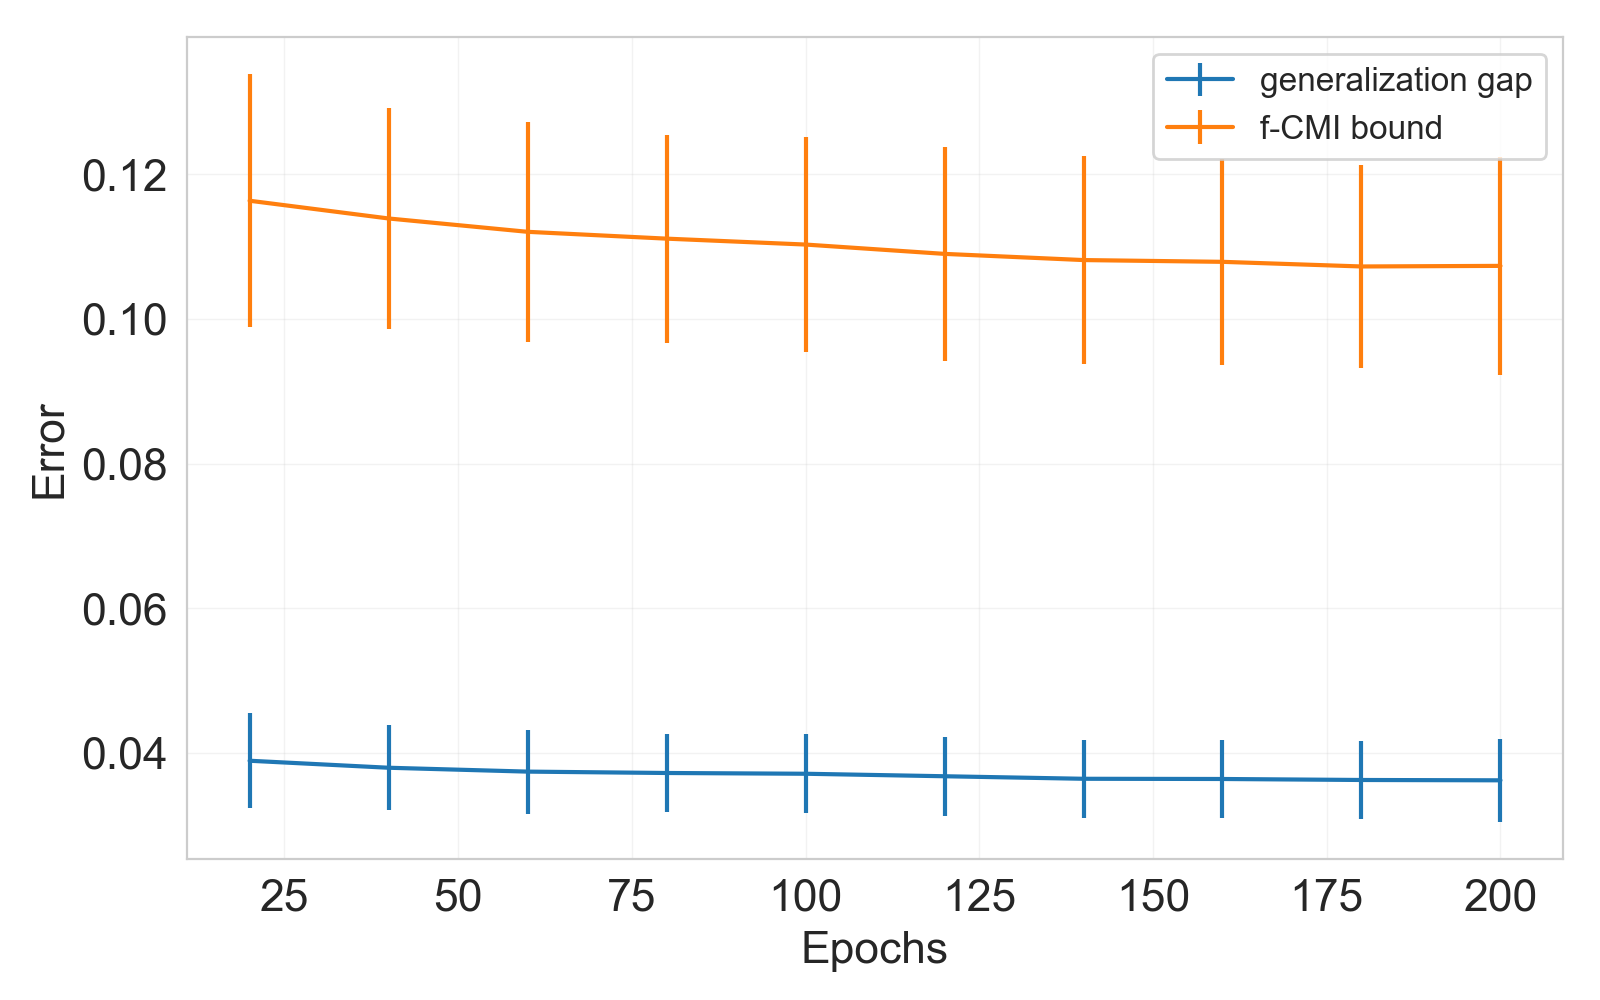

<IPython.core.display.Javascript object>


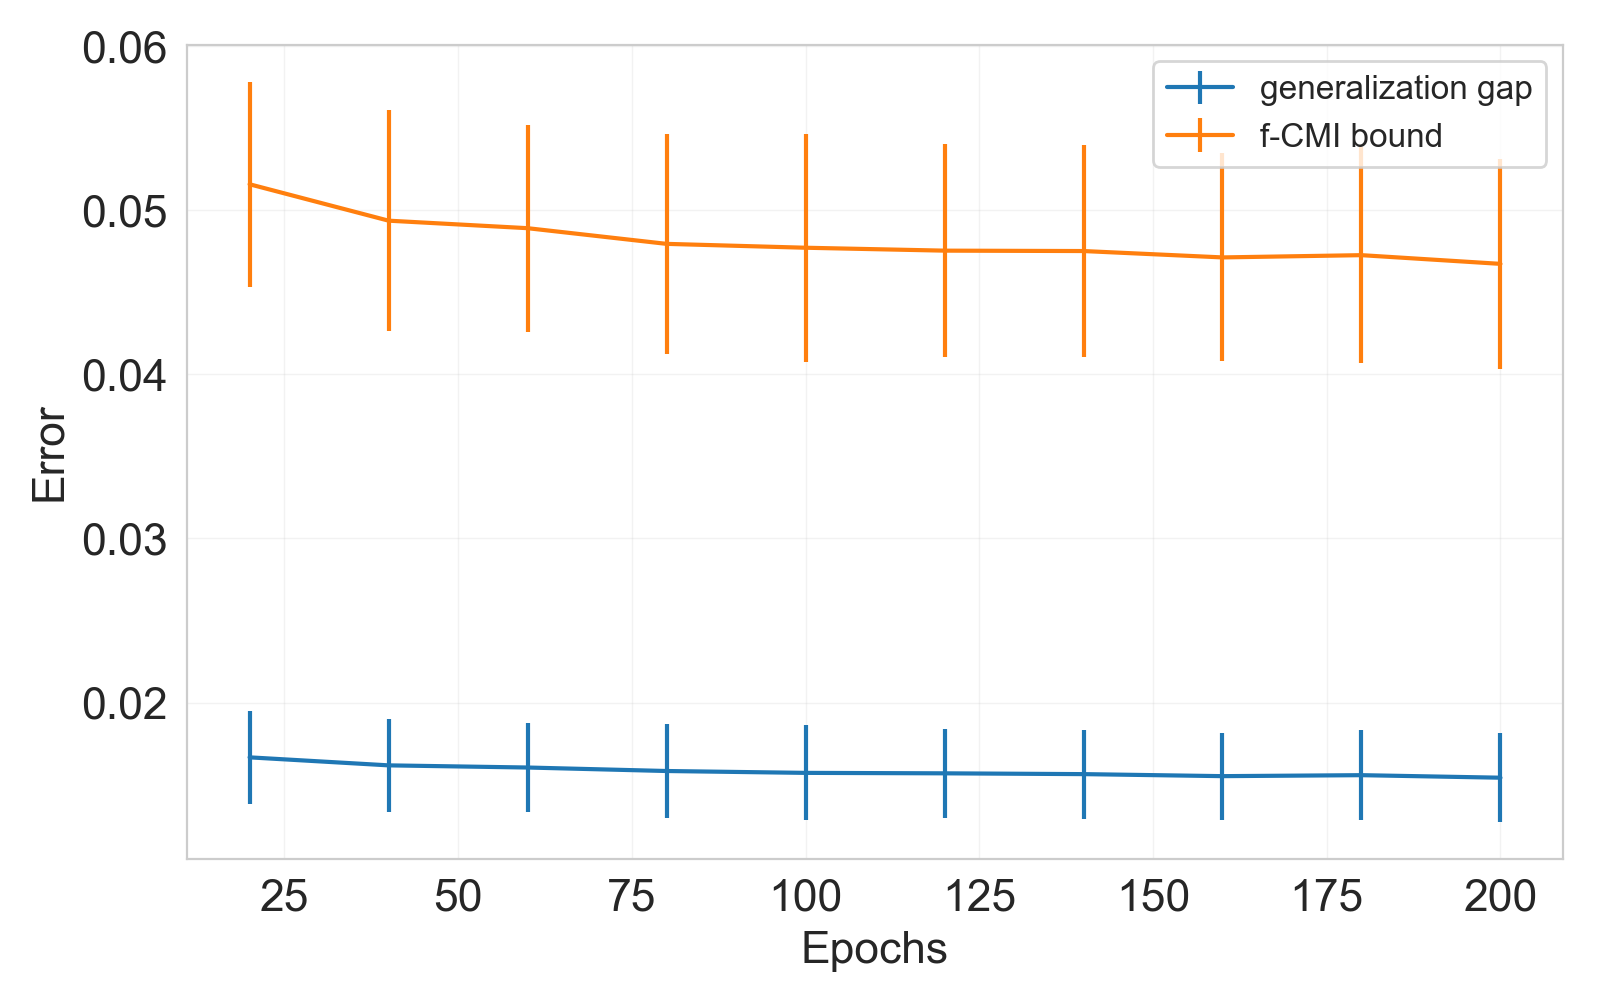

<IPython.core.display.Javascript object>


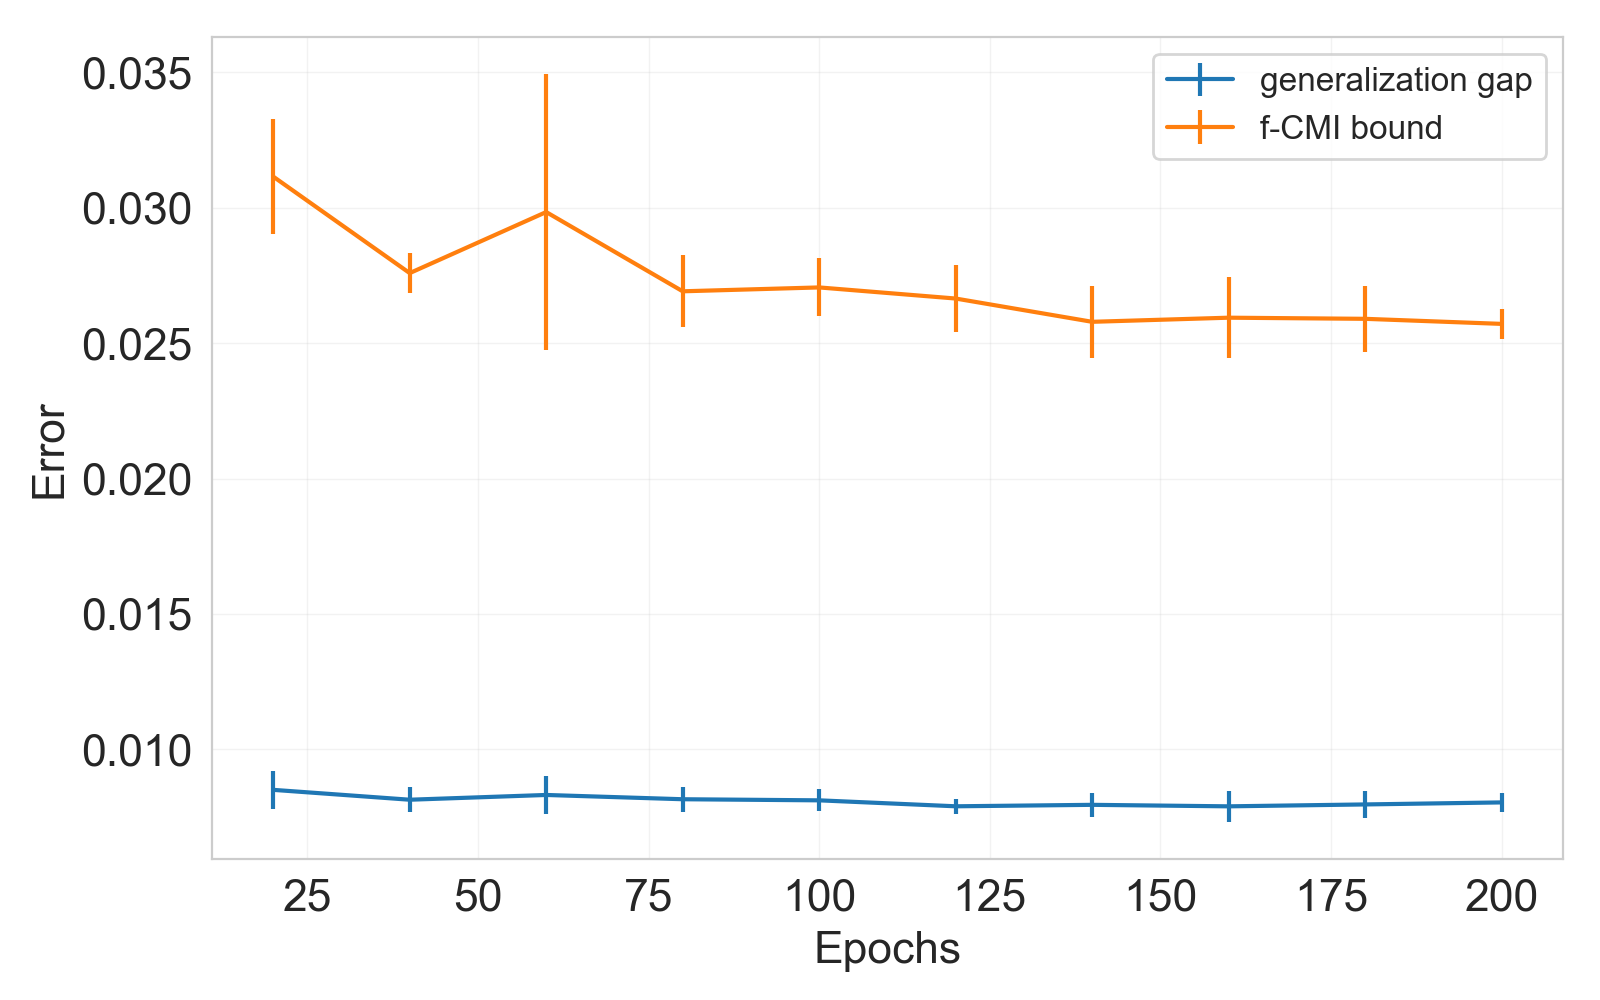

In [13]:
# x=epochs plot
for n in ns:
    fig, ax = plt.subplots(figsize=(8, 5))

    fcmi_means = []
    fcmi_stds = []
    gap_means = []
    gap_stds = []
    for epoch in epochs:
        fcmi_mean = np.nanmean([d['fcmi_bound'] for d in results[n][epoch]])
        fcmi_std = np.nanstd([d['fcmi_bound'] for d in results[n][epoch]])
        gap_mean = np.nanmean([d['exp_gap'] for d in results[n][epoch]])
        gap_std = np.nanstd([d['exp_gap'] for d in results[n][epoch]])

        fcmi_means.append(fcmi_mean)
        fcmi_stds.append(fcmi_std)
        gap_means.append(gap_mean)
        gap_stds.append(gap_std)

    ax.errorbar(x=epochs, y=gap_means, yerr=gap_stds, label=f'generalization gap')
    ax.errorbar(x=epochs, y=fcmi_means, yerr=fcmi_stds, label=f'f-CMI bound')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Error')
    ax.legend()
    fig.tight_layout()
    savefig(fig, os.path.join(results_dir, exp_name, f'main-plot-n={n}.pdf'))

<IPython.core.display.Javascript object>


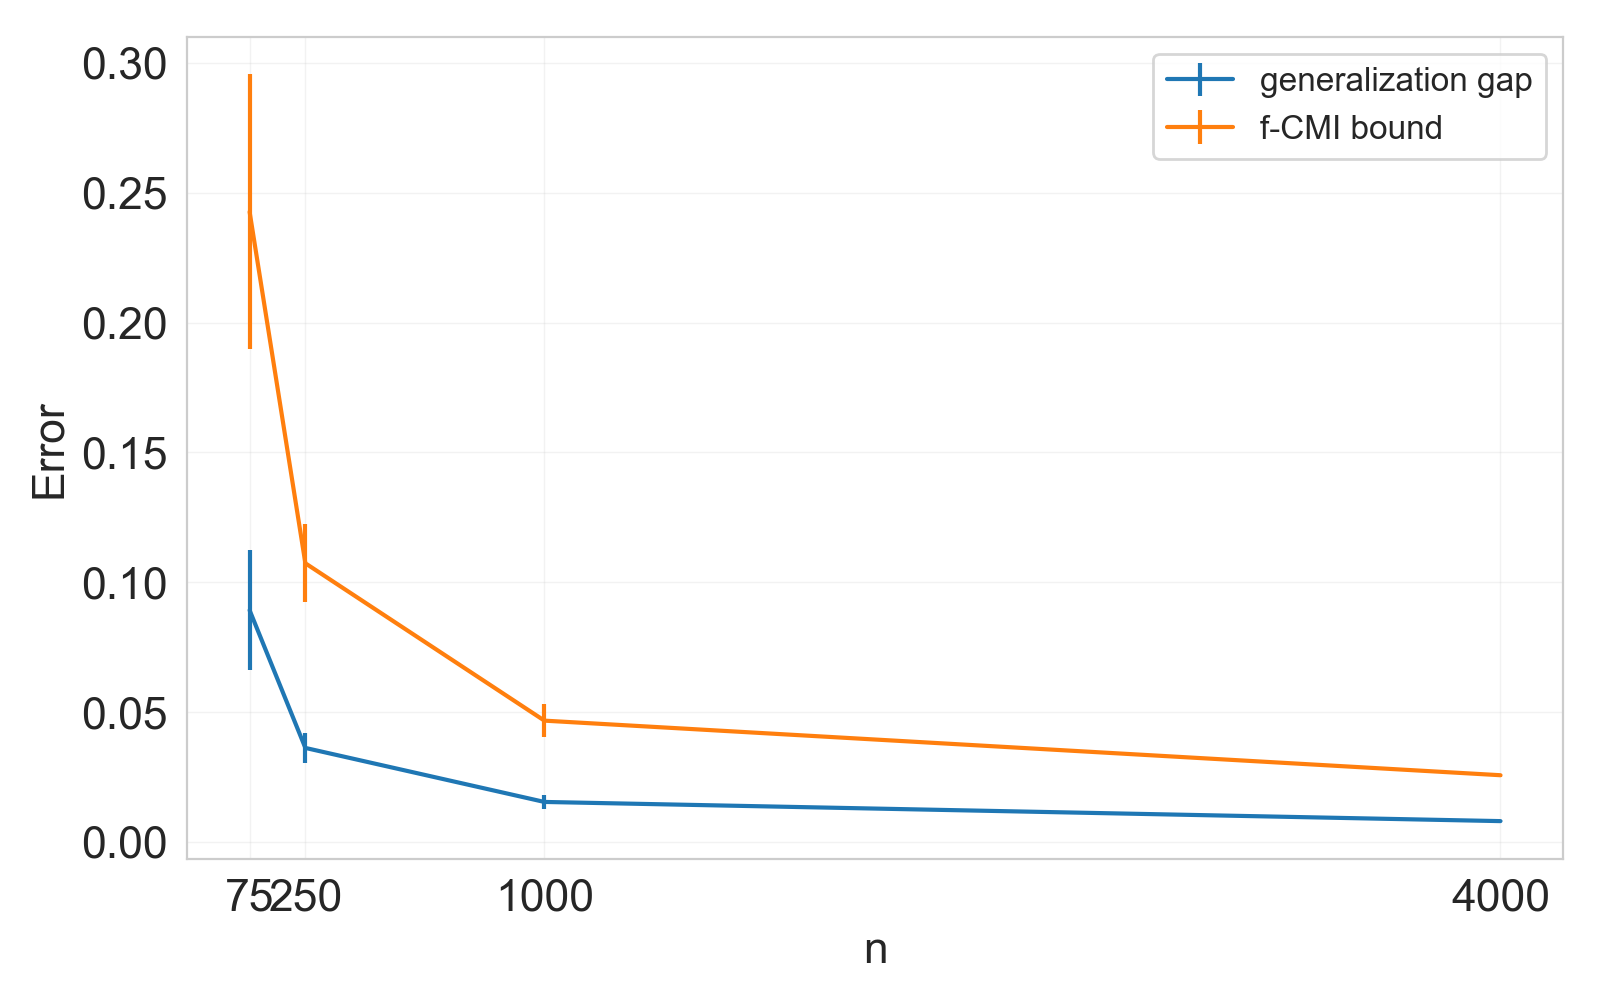

In [14]:
# x=n plot, last epoch
fig, ax = plt.subplots(figsize=(8, 5))

fcmi_means = []
fcmi_stds = []
gap_means = []
gap_stds = []

for n in ns:
    fcmi_mean = np.nanmean([d['fcmi_bound'] for d in results[n][epochs[-1]]])
    fcmi_std = np.nanstd([d['fcmi_bound'] for d in results[n][epochs[-1]]])
    gap_mean = np.nanmean([d['exp_gap'] for d in results[n][epochs[-1]]])
    gap_std = np.nanstd([d['exp_gap'] for d in results[n][epochs[-1]]])
    fcmi_means.append(fcmi_mean)
    fcmi_stds.append(fcmi_std)
    gap_means.append(gap_mean)
    gap_stds.append(gap_std)

ax.errorbar(x=ns, y=gap_means, yerr=gap_stds, label=f'generalization gap')
ax.errorbar(x=ns, y=fcmi_means, yerr=fcmi_stds, label=f'f-CMI bound')
ax.set_xlabel('n')
ax.set_ylabel('Error')
ax.set_xticks(ns)
ax.legend()
fig.tight_layout()
savefig(fig, os.path.join(results_dir, exp_name, f'x=n-plot.pdf'))

# Plot with deterministic algorithm

In [16]:
results_file_path = os.path.join(results_dir, f'{exp_name}', 'results.pkl')
with open(results_file_path, 'rb') as f:
    results_stochastic = pickle.load(f)

In [17]:
results_file_path = os.path.join(results_dir, f'{exp_name}-deterministic', 'results.pkl')
with open(results_file_path, 'rb') as f:
    results_deterministic = pickle.load(f)

In [25]:
exp_name = 'fcmi-mnist-4vs9-wide-CNN-deterministic'
results_file_path = os.path.join(results_dir, f'{exp_name}', 'results.pkl')
with open(results_file_path, 'rb') as f:
    results_wide_deterministic = pickle.load(f)

<IPython.core.display.Javascript object>


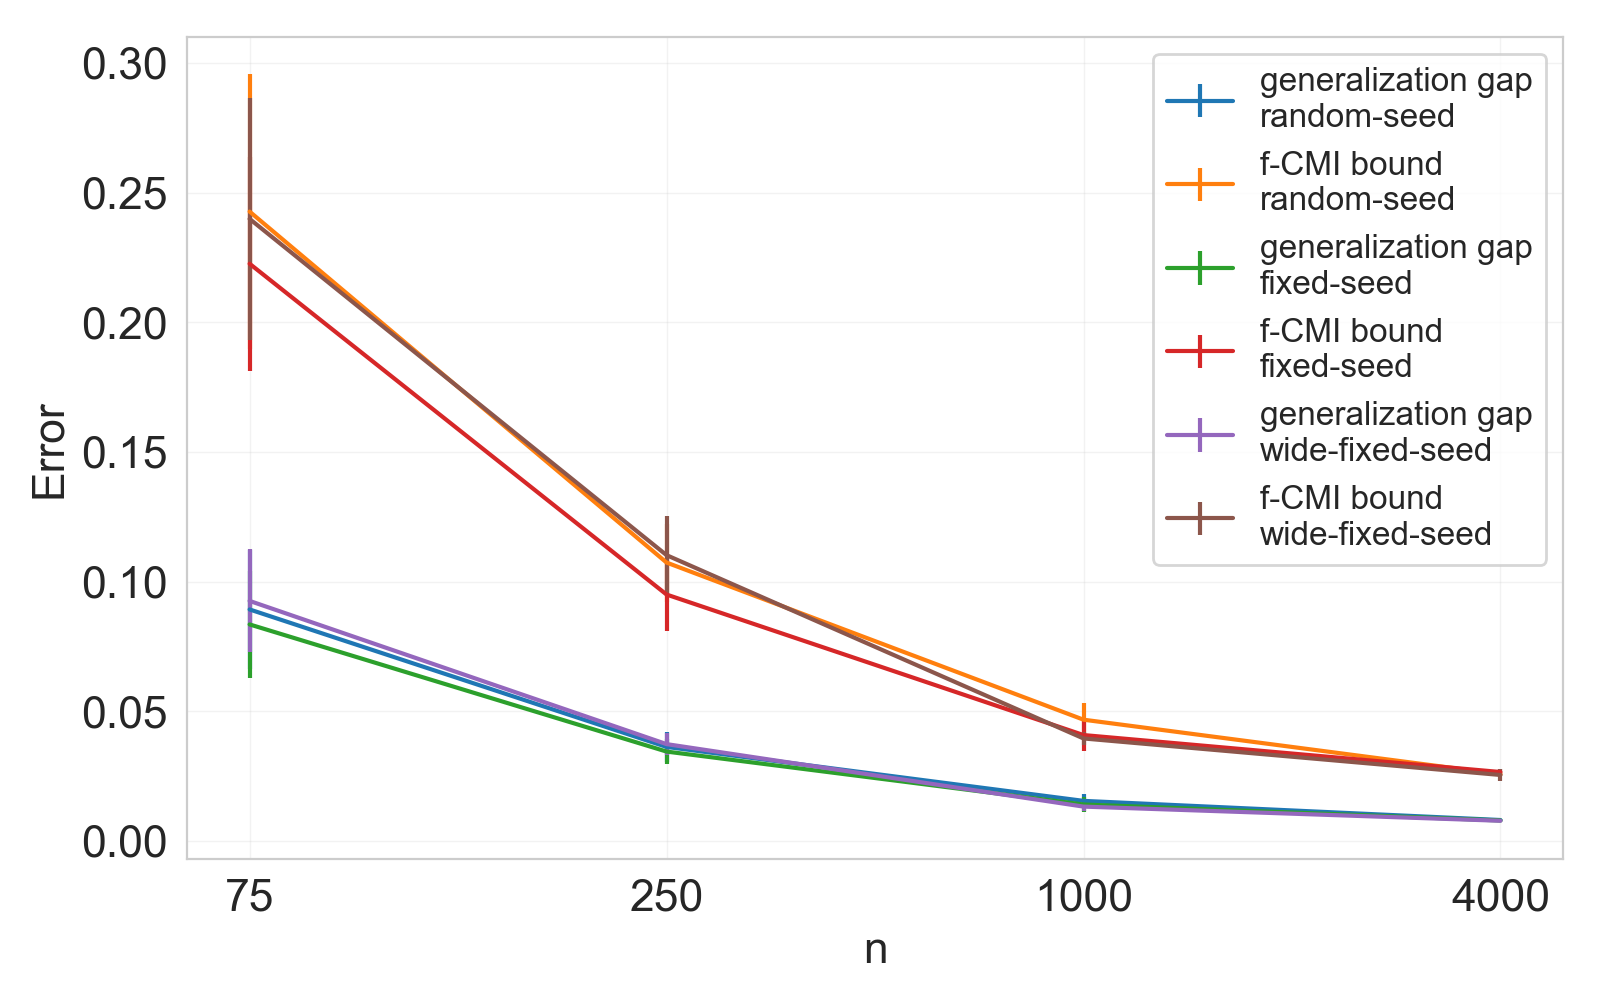

In [26]:
# x=n plot, last epoch
fig, ax = plt.subplots(figsize=(8, 5))

for name, results in zip(['random-seed', 'fixed-seed', 'wide-fixed-seed'], 
                          [results_stochastic, results_deterministic, results_wide_deterministic]):
    fcmi_means = []
    fcmi_stds = []
    gap_means = []
    gap_stds = []

    for n in ns:
        fcmi_mean = np.nanmean([d['fcmi_bound'] for d in results[n][epochs[-1]]])
        fcmi_std = np.nanstd([d['fcmi_bound'] for d in results[n][epochs[-1]]])
        gap_mean = np.nanmean([d['exp_gap'] for d in results[n][epochs[-1]]])
        gap_std = np.nanstd([d['exp_gap'] for d in results[n][epochs[-1]]])
        fcmi_means.append(fcmi_mean)
        fcmi_stds.append(fcmi_std)
        gap_means.append(gap_mean)
        gap_stds.append(gap_std)

    ax.errorbar(x=range(len(ns)), y=gap_means, yerr=gap_stds, label=f'generalization gap\n{name}')
    ax.errorbar(x=range(len(ns)), y=fcmi_means, yerr=fcmi_stds, label=f'f-CMI bound\n{name}')
ax.set_xlabel('n')
ax.set_ylabel('Error')
ax.set_xticks(range(len(ns)))
ax.set_xticklabels(ns)
ax.legend()
fig.tight_layout()
# savefig(fig, os.path.join(results_dir, exp_name, f'x=n-plot.pdf'))

# MNIST 4 vs 9 (Langevin Dynamics)

In [6]:
results_dir = "results"
exp_name = "fcmi-mnist-4vs9-CNN-LD"
n_seeds = 5
n_S_seeds = 30
n = 4000
ns = [4000]
epochs = np.arange(1, 11) * 4
num_classes = 2
batch_size = 100

In [7]:
results_file_path = os.path.join(results_dir, f'{exp_name}', 'results.pkl')
with open(results_file_path, 'rb') as f:
    fcmi_results = pickle.load(f)
    
results_file_path = os.path.join(results_dir, f'{exp_name}', 'sgld_results.pkl')
with open(results_file_path, 'rb') as f:
    sgld_results = pickle.load(f)

In [9]:
fcmi_results

{4000: {4: [{'exp_train_acc': 0.9098666666666667,
    'exp_val_acc': 0.9174833333333334,
    'exp_gap': -0.007616666666666716,
    'fcmi_bound': 0.21301228301939965},
   {'exp_train_acc': 0.8962333333333333,
    'exp_val_acc': 0.8976916666666666,
    'exp_gap': -0.0014583333333332282,
    'fcmi_bound': 0.16557359218517154},
   {'exp_train_acc': 0.9007166666666666,
    'exp_val_acc': 0.9061416666666667,
    'exp_gap': -0.005425000000000124,
    'fcmi_bound': 0.21492436140459764},
   {'exp_train_acc': 0.9124666666666666,
    'exp_val_acc': 0.9197749999999999,
    'exp_gap': -0.00730833333333325,
    'fcmi_bound': 0.17894849833352636},
   {'exp_train_acc': 0.9148833333333335,
    'exp_val_acc': 0.9262583333333334,
    'exp_gap': -0.011374999999999913,
    'fcmi_bound': 0.1928467010217529}],
  8: [{'exp_train_acc': 0.9574333333333335,
    'exp_val_acc': 0.9565833333333333,
    'exp_gap': 0.0008500000000001284,
    'fcmi_bound': 0.07860853496490652},
   {'exp_train_acc': 0.9454416666666667,

In [8]:
sgld_results

{4000: {4: [{'train_acc': 0.83675,
    'val_acc': 0.853,
    'gap': 0.016249999999999987,
    'sgld_bound': 0.00711015445956291},
   {'train_acc': 0.5605,
    'val_acc': 0.6787500000000001,
    'gap': 0.11825000000000008,
    'sgld_bound': 0.0056519453330074985},
   {'train_acc': 0.5787500000000001,
    'val_acc': 0.709,
    'gap': 0.13024999999999987,
    'sgld_bound': 0.005440868804033651},
   {'train_acc': 0.539,
    'val_acc': 0.5755,
    'gap': 0.03649999999999998,
    'sgld_bound': 0.004415849867681342},
   {'train_acc': 0.6865,
    'val_acc': 0.7072499999999999,
    'gap': 0.020749999999999935,
    'sgld_bound': 0.006157831428335702},
   {'train_acc': 0.748,
    'val_acc': 0.78075,
    'gap': 0.03275000000000006,
    'sgld_bound': 0.005458559285974641},
   {'train_acc': 0.67675,
    'val_acc': 0.6910000000000001,
    'gap': 0.014250000000000096,
    'sgld_bound': 0.005355156541235198},
   {'train_acc': 0.60725,
    'val_acc': 0.70675,
    'gap': 0.09950000000000003,
    'sgld_bo

<IPython.core.display.Javascript object>


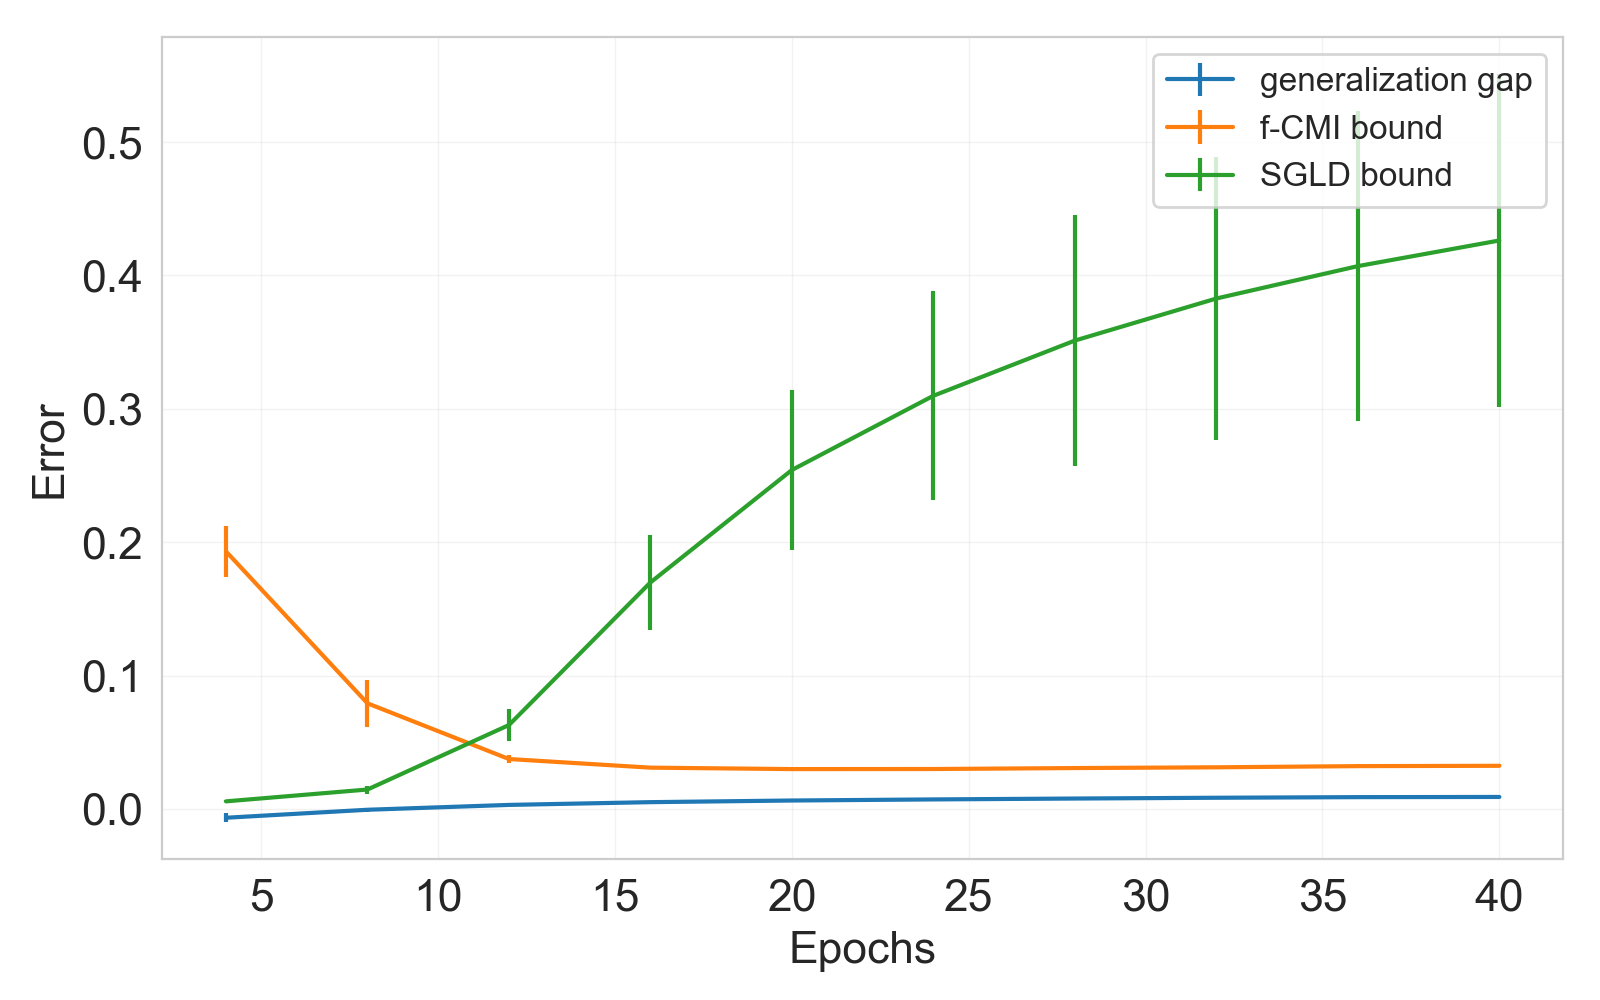

In [15]:
# x=epochs plot
fig, ax = plt.subplots(figsize=(8, 5))

fcmi_means = []
fcmi_stds = []
gap_means = []
gap_stds = []

sgld_means = []
sgld_stds = []
sgld_means = []
sgld_stds = []

for epoch in epochs:
    fcmi_mean = np.nanmean([d['fcmi_bound'] for d in fcmi_results[n][epoch]])
    fcmi_std = np.nanstd([d['fcmi_bound'] for d in fcmi_results[n][epoch]])
    gap_mean = np.nanmean([d['exp_gap'] for d in fcmi_results[n][epoch]])
    gap_std = np.nanstd([d['exp_gap'] for d in fcmi_results[n][epoch]])

    fcmi_means.append(fcmi_mean)
    fcmi_stds.append(fcmi_std)
    gap_means.append(gap_mean)
    gap_stds.append(gap_std)
    
    sgld_mean = np.nanmean([d['sgld_bound'] for d in sgld_results[n][epoch]])
    sgld_std = np.nanstd([d['sgld_bound'] for d in sgld_results[n][epoch]])
    sgld_means.append(sgld_mean)
    sgld_stds.append(sgld_std)

ax.errorbar(x=epochs, y=gap_means, yerr=gap_stds, label=f'generalization gap')
ax.errorbar(x=epochs, y=fcmi_means, yerr=fcmi_stds, label=f'f-CMI bound')
ax.errorbar(x=epochs, y=sgld_means, yerr=sgld_stds, label=f'SGLD bound')

ax.set_xlabel('Epochs')
ax.set_ylabel('Error')
ax.legend()
fig.tight_layout()
# savefig(fig, os.path.join(results_dir, exp_name, f'main-plot-n={n}.pdf'))

In [ ]:
# TODO: plot with shadding
# Round markers